In [1]:
# import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

from pandas import set_option
#set_option('precision',5)
pd.options.display.float_format = '{:.5f}'.format


# Import Libraries and packages from tensorflow.Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
# read the data

dataset = pd.read_csv('US_Gold_stockdata.csv',index_col='Date',parse_dates=True,infer_datetime_format=True)

In [3]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-01,nan,nan,nan,nan,nan,nan
2001-01-02,268.39999,268.39999,268.39999,268.39999,268.39999,0.00000
2001-01-03,268.00000,268.00000,268.00000,268.00000,268.00000,1.00000
2001-01-04,267.29999,267.29999,267.29999,267.29999,267.29999,1.00000
2001-01-05,268.00000,268.00000,268.00000,268.00000,268.00000,0.00000


In [4]:
# drop null values and Volume column

dataset.dropna(axis = 0, inplace = True) 
dataset.drop(['Volume','Adj Close'], axis = 1, inplace = True) 

In [5]:
dataset.head()

,Open,High,Low,Close
Date,,,,
2001-01-02,268.39999,268.39999,268.39999,268.39999
2001-01-03,268.00000,268.00000,268.00000,268.00000
2001-01-04,267.29999,267.29999,267.29999,267.29999
2001-01-05,268.00000,268.00000,268.00000,268.00000
2001-01-08,268.00000,268.00000,268.00000,268.00000


In [6]:
datelist = dataset.index
datelist[:5]

DatetimeIndex(['2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05',
               '2001-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
print(f"Training set shape: {dataset.shape}")
print(f"Date list shape: {datelist.shape}")
print(f"Features in training set: {dataset.columns}")

Training set shape: (5058, 4)
Date list shape: (5058,)
Features in training set: Index(['Open', 'High', 'Low', 'Close'], dtype='object')


C:\Users\DELL\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


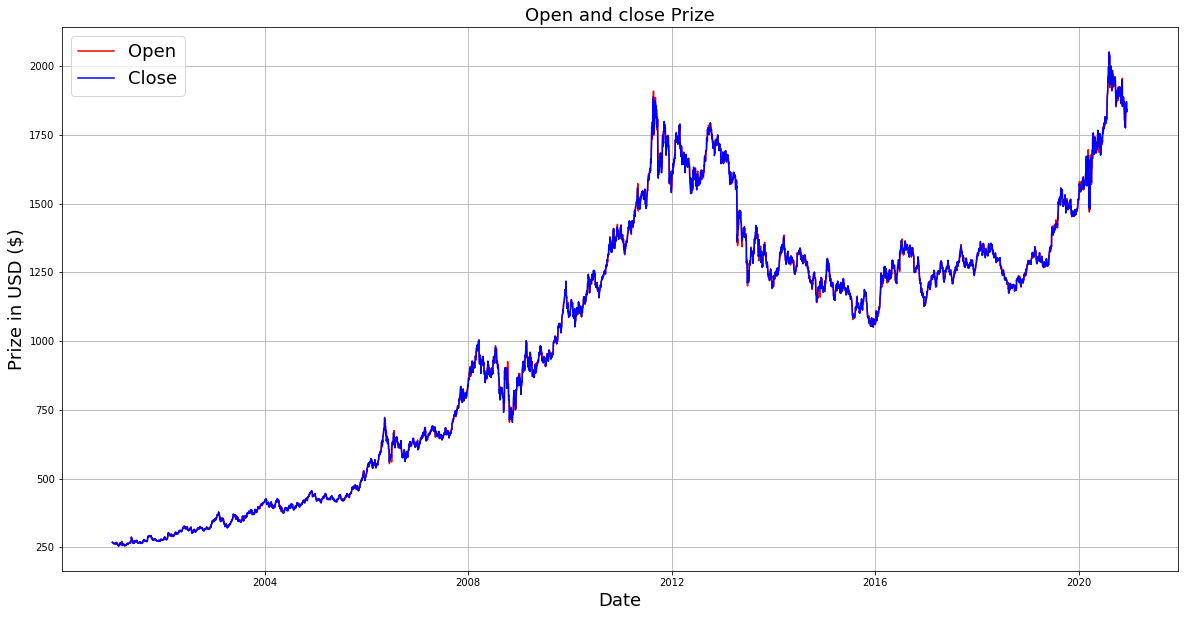

In [8]:
# visualization

plt.figure(figsize=(20,10))
plt.title('Open and close Prize', fontsize=18)
plt.plot(dataset['Open'], label = 'Open', color = 'r')
plt.plot(dataset['Close'], label = 'Close', color = 'b')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prize in USD ($)', fontsize=18)
plt.legend( fontsize=18)
plt.grid()
plt.show()

In [9]:
# some preprocessing and data preparation steps 

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5058 entries, 2001-01-02 to 2020-12-11
Data columns (total 4 columns):
Open     5058 non-null float64
High     5058 non-null float64
Low      5058 non-null float64
Close    5058 non-null float64
dtypes: float64(4)
memory usage: 197.6 KB


In [10]:
data = dataset.iloc[:].values
print(f"Shape of traning set: {data.shape}")
data

Shape of traning set: (5058, 4)


array([[ 268.399994,  268.399994,  268.399994,  268.399994],
       [ 268.      ,  268.      ,  268.      ,  268.      ],
       [ 267.299988,  267.299988,  267.299988,  267.299988],
       ...,
       [1867.099976, 1867.099976, 1827.      , 1834.599976],
       [1833.199951, 1849.099976, 1828.      , 1833.599976],
       [1840.      , 1851.800049, 1826.800049, 1842.699951]])

In [11]:
# all the data should be on the same scale for training RNN network
# because large values can have high impact on the predictions
# And also RNN works well when values are on the same scale

from sklearn.preprocessing import StandardScaler

# one standaard scaler for independent variable 
scaler = StandardScaler()
traning_data_scaled = scaler.fit_transform(data)

# one standaard scaler for dependent variable that we want to predict
scaler_predict = StandardScaler()
predict_data_scaled = scaler_predict.fit_transform(data[:,0:1])
predict_data_scaled

array([[-1.57840676],
       [-1.57925074],
       [-1.58072775],
       ...,
       [ 1.79480735],
       [ 1.72327921],
       [ 1.73762713]])

In [54]:
# creating the dataset for model traning and prediction

X_train = []
y_train = []

n_future = 60   # number of days we need to predict into future
n_past = 90     # number of days we want to use to predict the future

for i in range(n_past, len(traning_data_scaled) - n_future + 1):
    X_train.append(traning_data_scaled[i - n_past:i, 0: data.shape[1]]) # 0: data.shape[1]-1 # [i - n_past: i, 0: data.shape[1]]
    y_train.append(predict_data_scaled[i-1:i, 0])# i + n_future-1:i + n_future
    
X_train, y_train = np.array(X_train), np.array(y_train)
    
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (4909, 90, 4)
y_train shape: (4909, 1)


In [55]:
X_train[0].shape

(90, 4)

In [56]:
# creating a model
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape = X_train[0].shape))

# Adding 2nd LSTM layer
model.add(LSTM(units=32, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

In [57]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
tb = TensorBoard('logs')

history = model.fit(X_train, y_train, epochs=15, callbacks=[es, rlr], validation_split=0.2, verbose=1, batch_size=128)

Epoch 1/15
31/31 [==============================] - 5s 165ms/step - loss: 0.1809 - val_loss: 0.0268 - lr: 0.0010
Epoch 2/15
31/31 [==============================] - 4s 143ms/step - loss: 0.0271 - val_loss: 0.0073 - lr: 0.0010
Epoch 3/15
31/31 [==============================] - 4s 137ms/step - loss: 0.0201 - val_loss: 0.0053 - lr: 0.0010
Epoch 4/15
31/31 [==============================] - 4s 139ms/step - loss: 0.0158 - val_loss: 0.0059 - lr: 0.0010
Epoch 5/15
31/31 [==============================] - 4s 138ms/step - loss: 0.0147 - val_loss: 0.0045 - lr: 0.0010
Epoch 6/15
31/31 [==============================] - 4s 134ms/step - loss: 0.0142 - val_loss: 0.0042 - lr: 0.0010
Epoch 7/15
31/31 [==============================] - 4s 137ms/step - loss: 0.0132 - val_loss: 0.0059 - lr: 0.0010
Epoch 8/15
31/31 [==============================] - 4s 136ms/step - loss: 0.0128 - val_loss: 0.0057 - lr: 0.0010
Epoch 9/15
31/31 [==============================] - 4s 136ms/step - loss: 0.0133 - val_loss: 0.0

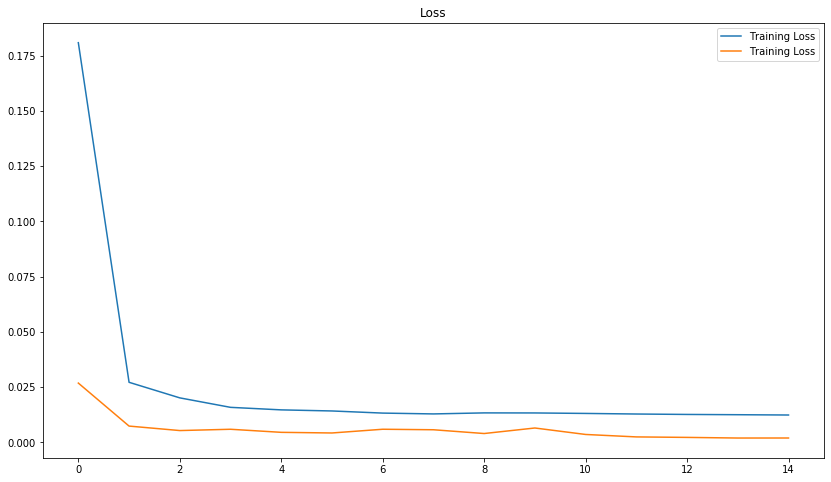

In [58]:
plt.plot(history.history['loss'],label ="Training Loss")
plt.plot(history.history['val_loss'],label ="Training Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [59]:
# make Future Predictions

datelist_future = pd.date_range(datelist[-1], periods=n_future, freq='1d').to_list()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
#datelist_future_ = []
#for this_timestamp in datelist_future:
#    datelist_future_.append(this_timestamp.date())

In [60]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

y_pred_future = scaler_predict.inverse_transform(predictions_future)
y_pred_train = scaler_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))



PREDICTION_TRAIN.head(3)

,Open
Date,
2001-12-18,288.65524
2001-12-19,290.02536
2001-12-20,291.22086


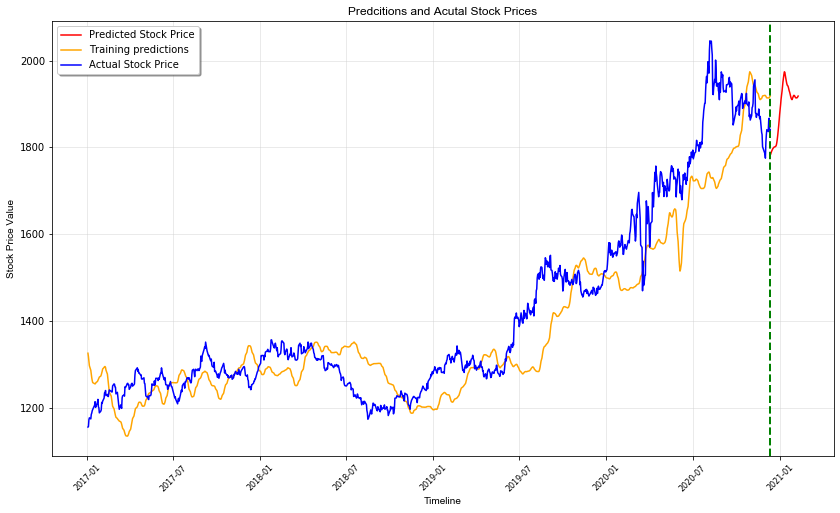

In [63]:
# Plot parameters
rcParams['figure.figsize'] = 14, 8

START_DATE_FOR_PLOTTING = '2017-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset.loc[START_DATE_FOR_PLOTTING:].index, dataset.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [62]:
PREDICTIONS_FUTURE

,Open
2020-12-11,1781.74646
2020-12-12,1783.89014
2020-12-13,1787.23376
2020-12-14,1790.50305
2020-12-15,1793.03210
2020-12-16,1795.35645
2020-12-17,1797.60364
2020-12-18,1798.65759
2020-12-19,1800.18579
2020-12-20,1800.75598
